In [1]:
import glob, os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import smart_resize
import pandas as pd


In [2]:
tf.config.experimental.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

## Preprocessing

In [4]:
img_meta_df = pd.read_csv("data/crop_metadata.csv")

In [5]:
data_labels = img_meta_df.dropna(subset=['family']).sort_values(by='file_name')['family'].values
data_lables_or_enc = OrdinalEncoder().fit_transform(data_labels.reshape(-1, 1)).astype('int32')


In [6]:
def unwrap(data):
    return data[0]
data_lables_or_enc_unwrapped = map(unwrap, data_lables_or_enc)

In [130]:
dir_path = os.path.join(os.path.realpath(os.getcwd()), "data")

loaded_images = image_dataset_from_directory(dir_path, labels=list(data_lables_or_enc_unwrapped), label_mode='categorical')

Found 80809 files belonging to 1 classes.


In [131]:
loaded_images

<BatchDataset shapes: ((None, 256, 256, 3), (None, 1)), types: (tf.float32, tf.float32)>

In [24]:
import sys

dirname = "./data/crops"

(img_height, img_width) = (50, 50)
n_samples = 1000

img_df = pd.DataFrame()

for n, (index, row) in enumerate(img_meta_df.iterrows()):
    path_name = os.path.join(dirname, row['file_name'])

    if os.path.exists(path_name):
        
        loaded_img = load_img(path_name,  color_mode="grayscale", target_size=(img_height, img_width), interpolation="nearest")
        img_array = img_to_array(loaded_img)
        #img_array = np.resize(img_array, (1, img_height, img_width))
        #img_array = [np.ndarray.flatten(x) for x in img_array]
        row["img_array"] = img_array
        img_df = img_df.append(row)
        if(n%n_samples == 0):
            print("{} samples processed\r".format(n), end="", flush=True)


In [25]:
img_df.to_csv("./data/image_csv.csv")

In [31]:
img_df = img_df.dropna(subset=['family'])

In [32]:
img_df['img_array'].values[0][0][0]

array([84.], dtype=float32)

In [33]:
y = img_df['family'].to_numpy()
data = np.array(img_df['img_array'].values.tolist())

In [34]:
data.shape

(80809, 50, 50, 1)

In [35]:
import matplotlib.pyplot as plt
import itertools

def show_images_sample(generator, root_sample_size):
    fig, axs = plt.subplots(root_sample_size, root_sample_size, figsize=(15,15))
    img_arrays = list(itertools.islice(generator, root_sample_size**2))

    i=0
    for row in axs:
        for ax in row:
            ax.imshow(img_arrays[i])
            i+=1

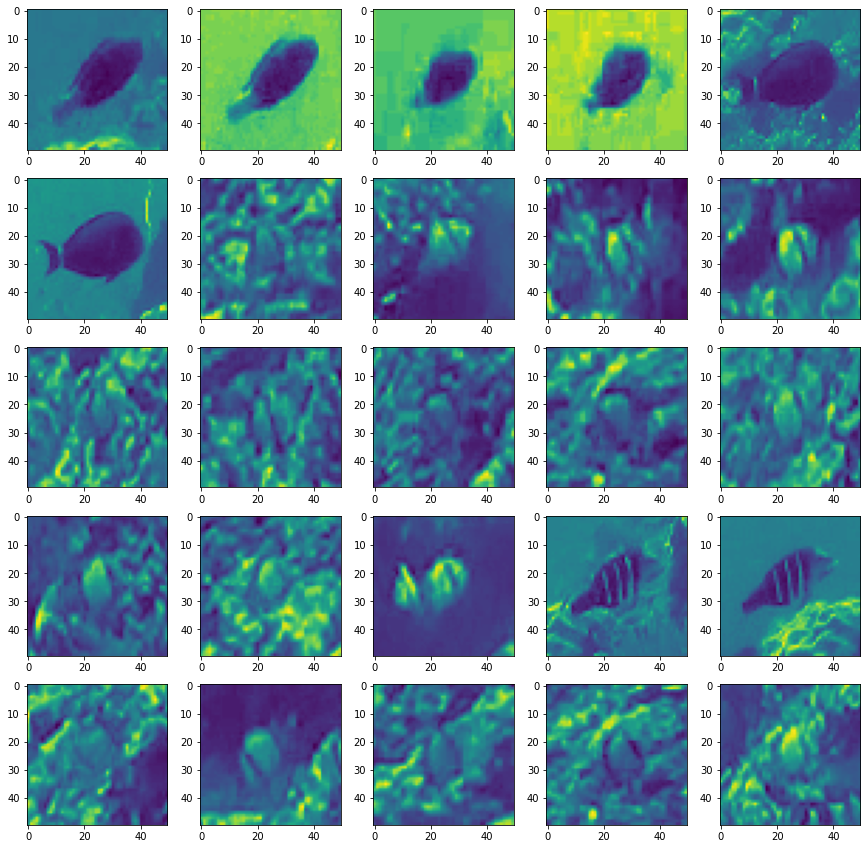

In [36]:
show_images_sample(data, 5)

## Data Setup

In [91]:
X_train, X_test, y_train, y_test = train_test_split(data, y, train_size = 0.8)

In [120]:
oh_enc = OneHotEncoder(handle_unknown='ignore').fit(y.reshape(-1,1))
y_train_ohe = oh_enc.transform(y_train.reshape(-1,1))
y_test_ohe = oh_enc.transform(y_test.reshape(-1,1))

In [93]:
or_enc = OrdinalEncoder().fit(y.reshape(-1,1))
y_train_ore = or_enc.transform(y_train.reshape(-1,1))
y_test_ore = or_enc.transform(y_test.reshape(-1,1))

In [94]:
X_train.shape

(64647, 50, 50, 1)

In [144]:
X_train_tensor = tf.convert_to_tensor(X_train)
y_train_tensor = tf.convert_to_tensor(y_train_ohe.toarray())

X_test_tensor = tf.convert_to_tensor(X_test)
y_test_tensor = tf.convert_to_tensor(y_test_ohe.toarray())

In [145]:
input_shape = X_train_tensor[0].shape
num_classes = y_train_ohe.toarray()[0].shape[0]
print("Input shape:", input_shape, "\nNumber of classes:", num_classes)

Input shape: (50, 50, 1) 
Number of classes: 74


In [146]:
datagen = ImageDataGenerator(
    featurewise_std_normalization=True,
)

datagen_data = X_train_tensor
#datagen_data = [[[[z] for z in y] for y in x] for x in X_train]

datagen.fit(datagen_data)

train_iterator = datagen.flow(X_train_tensor, y_train_tensor)
test_iterator = datagen.flow(X_test_tensor, y_test_tensor)

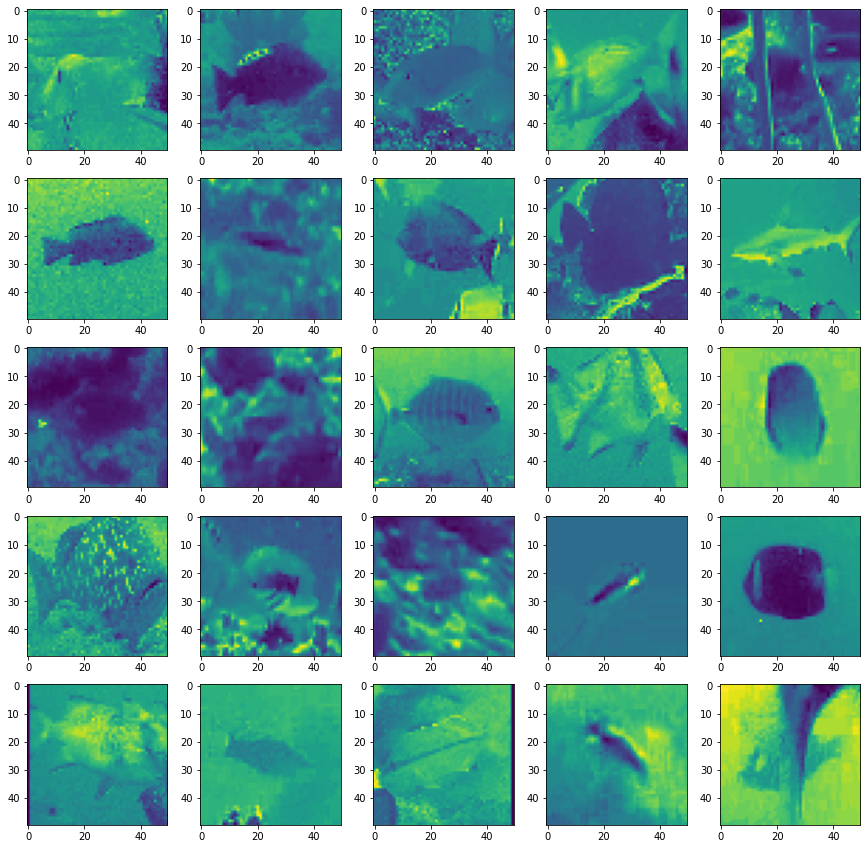

In [148]:
show_images_sample(next(train_iterator)[0], 5)

## Model Setup

In [199]:
drop_rate = .3

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1),activation='relu',input_shape=input_shape))
model.add(tf.keras.layers.SpatialDropout2D(drop_rate))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, (2, 2), strides=(1, 1), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1000, activation='relu'))

model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
             )


In [200]:
[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
[print(l.name) for l in model.layers]

(None, 50, 50, 1) <dtype: 'float32'>
(None, 74) <dtype: 'float32'>
conv2d_24
spatial_dropout2d_12
max_pooling2d_24
conv2d_25
max_pooling2d_25
flatten_12
dense_24
dense_25


[None, None, None, None, None, None, None, None]

In [206]:
MODEL_WEIGHTS_PATH = "model_weights"

if(os.path.exists(MODEL_WEIGHTS_PATH)):
    model.load_wweights("model_weights")
else:
    model.fit(train_iterator, epochs=10, verbose=1)

Epoch 1/10
  28/2021 [..............................] - ETA: 2:57 - loss: 0.1680 - accuracy: 0.9554 ETA: 2:47 - loss: 0.1542 - ac - ETA: 2:50 - loss: 0.1713 - ac

KeyboardInterrupt: 

In [202]:
model.evaluate(test_iterator)

506/506 [==============================] - 9s 18ms/step - loss: 2.3649 - accuracy: 0.6134


[2.3649048805236816, 0.6133522987365723]

In [205]:
model.save_weights(MODEL_WEIGHTS_PATH)

In [203]:
next(test_iterator)[0][0].shape

(50, 50, 1)

In [204]:
sample = next(test_iterator)[0]

predictions = model.predict(sample)

for prediction in predictions:
    print(or_enc.inverse_transform(prediction.argmax().reshape(-1, 1))[0][0])

Lethrinidae
Blenniidae
Scaridae
Pinguipedidae
Lutjanidae
Serranidae
Lethrinidae
Pomacentridae
Mullidae
Labridae
Labridae
Labridae
Lutjanidae
Lethrinidae
Acanthuridae
Caesionidae
Labridae
Scaridae
Pomacentridae
Carangidae
Carangidae
Labridae
Acanthuridae
Serranidae
Chaetodontidae
Pomacanthidae
Lethrinidae
Lethrinidae
Serranidae
Labridae
Balistidae
Acanthuridae
